### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import snippets as sp
reload(sp)

<module 'snippets' from '/gpfs/home/mep22dku/scratch/SOZONE/UTILS/snippets.py'>

In [4]:
sp.txr()

savenam = 'test2.nc'
data_vars = {'vomecrty':(['time_counter', 'depthv', 'y', 'x'], vomecrty.values,
{'units': 'µatm',
'long_name':'Surface ocean pCO2'}),
}
# define coordinates
coords = {'time_counter': (['time_counter'], time_counter),
		'time_centered': (['time_centered'], time_centered),
'nav_lat': (['y','x'], nav_lat),
'nav_lon': (['y','x'], nav_lon),
'depthv': (['depthv'], depthv)}
# define global attributes
attrs = {'made in':'SOZONE/MEDUSA/makeYearlyMEDUSAsubsetfiles.ipynb',
'desc': 'yearly medusa files, saving only variables of interest'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)
ds.to_netcdf(savenam)


## code and implementation to extract a 2d field (typically wfo or sos) from a ts

In [5]:
def make_yearlist(yrst, yrend, tr, dtype = 'grid_T'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/home/mep22dku/scratch/ModelRuns/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def save_2d(tr, yrst = 1950, yrend = 2020, tdat = 'wfo'):
    
    ySRs = xr.open_mfdataset(make_yearlist(yrst,yrend,f'TOM12_TJ_{tr}'))
    
    single_var = ySRs[tdat]
    new_ds = single_var.to_dataset()
    
    times = pd.date_range(f"{yrst}/01/01",f"{yrend+1}/01/01",freq='MS',closed='left')
    new_ds['time_counter'] = times

    try:
        new_ds.to_netcdf(f'./data/{tr}_{tdat}.nc')  
        print(f'saved ./data/{tr}_{tdat}.nc')
    except:
        print(f'some problem occured with {tr} {tdat}')

In [11]:
ex = True

runs = ['KFD1','KFD2','KFD3','KFD4','KFD5','KFD6','KDD1','KDD2']

runs = ['KWD0','KDD0','KFD0','KFD1','KFD2',\
        'KFD3','KFD4','KFD5','KFD6','KDD1',\
        'KDD2','KFD7','KDD3','KCW0','KCD0']
runs = ['KCW0','KCD0']

if ex:

    for r in runs:
        #save_2d(r, yrst = 1950, yrend = 2020, tdat = 'wfo')
        #save_2d(r, yrst = 1950, yrend = 2020, tdat = 'sos')
        save_2d(r, yrst = 1950, yrend = 2020, tdat = 'tos')
#remake with ok dates



saved ./data/KCW0_sos.nc
saved ./data/KCD0_sos.nc


## code and implementation to extract max amoc 

In [8]:
def make_yearlist_AMOC(yrst, yrend, tr, baseDir = '/gpfs/home/mep22dku/cdftools/MOCresults/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        tyr = yrs[i]
        ty = f'{baseDir}{tr}_1m_{tyr}0101*MOC.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def get_max_amoc(moc_dataset):

    atl_at_26 = np.squeeze(moc_dataset.zomsfatl.sel(y=94).values)
    tshape = np.shape(atl_at_26)
    len_ts = tshape[0]

    max_atl = np.zeros(len_ts)

    for i in range(0,len(max_atl)):
        max_atl[i] = np.nanmax(atl_at_26[i,:])
        
    return max_atl

def save_max_amoc(mod):
    
    KFD0_moc = make_yearlist_AMOC(1920, 2023, f'TOM12_TJ_{mod}')
    KFD0_mocdat = xr.open_mfdataset(KFD0_moc)
    KFD0_max_amoc = get_max_amoc(KFD0_mocdat)
    nicetime  = KFD0_mocdat.indexes['time_counter'].to_datetimeindex()
    data_vars = {'amoc':(['time_counter'], KFD0_max_amoc,),}
    coords = {'time_counter': (['time_counter'], nicetime)}
    KFD0_max_amoc = xr.Dataset(data_vars=data_vars,coords=coords)
    KFD0_max_amoc.to_netcdf(f'./data/{mod}_max_amoc.nc')
    print(f'saved ./data/{mod}_max_amoc.nc')

In [9]:
ex = True

runs = ['KWD0','KDD0','KFD0','KFD1','KFD2','KFD3',\
        'KFD4','KFD5','KFD6','KDD1','KDD2',]

runs = ['KWD0','KFD7','KDD3']
runs = ['KCW0','KCD0']


if ex:

    for r in runs:
        try:
            save_max_amoc(r)
        except:
            print(f'problem in amoc calc in {r}')

saved ./data/KCW0_max_amoc.nc
saved ./data/KCD0_max_amoc.nc


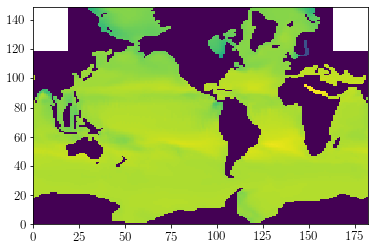

In [20]:
w = xr.open_dataset('./data/KCW0_sos.nc')

plt.pcolormesh(w.sos[500,:,:])

w = xr.open_dataset(f'./data/KCW0_sos.nc')
plt.pcolormesh(w['sos'][0,:,:])